In [15]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider

In [16]:
def gauss_pulse(
    t: npt.NDArray, 
    t_center: float, 
    sigma: float,
) -> tuple[npt.NDArray, npt.NDArray]:
    """
    Generate an LFM chirp signal

    Parameters
    ----------
    t: `[N,] float`
        Time samples

    t_center: `float`
        Center of Gaussian

    sigma: `float`
        Standard deviation

    Returns
    -------
    g_time: `[N,] float`
        Gaussian pulse in time domain

    g_freq: `[N,] float`
        Gaussian pulse in frequency domain
    """
    g_time = np.exp(-((t - t_center) ** 2) / (2 * sigma ** 2))
    freqs = np.fft.fftfreq(len(t), d=(t[1] - t[0]))  # Compute frequency axis
    # g_freq = sigma * np.sqrt(2 * np.pi) * np.exp(-2 * (np.pi * sigma * freqs) ** 2)
    g_freq = np.exp(-2 * (np.pi * sigma * freqs) ** 2)

    
    return g_time, g_freq



def fourier_tradeoff_demo(sigma=1):
    t = np.linspace(-10, 10, 1000)
    freqs = np.fft.fftfreq(len(t), d=(t[1] - t[0]))  # Compute frequency axis

    g_time, g_freq = gauss_pulse(t, 0, sigma)
    # Create the plot
    Fig = plt.figure(figsize=(10, 8))
    
    # Subplot 1: Waveforms
    Ax1 = plt.subplot(2, 1, 1)
    Ax1.plot(t, g_time)
    Ax1.set_title("Time Domain")
    Ax1.set_xlabel("t")
    Ax1.set_ylabel("Amplitude")
    Ax1.set_ylim((-2, 2))
    Ax1.grid()
    
    # Subplot 2: Convolution value
    Ax2 = plt.subplot(2, 1, 2)
    Ax2.plot(freqs, g_freq)
    Ax2.set_title("Frequency Domain")
    Ax2.set_ylabel("Amplitude")
    Ax2.set_ylim((-2, 2))
    Ax2.grid()
    
    plt.tight_layout()


## Problem

As we just saw, when trying to optimize for range resolution, shorter duration pulses are optimal. However, shortening the pulse duration comes at a cost. The shorter the pulse, the harder it is to achieve a high amount of energy on the target. Maximizing energy on the target will be important to achieving a high signal to noise ratio (SNR). Therefore, we need a way to achieve fine range resolution with a longer duration pulse.

## Frequency Modulation
Rather than using a short rectangular pulse with a duration $T_{rect} = \frac{1}{B}$, we instead spread the signal’s frequency content over a longer duration $T$. One way of achieving this is *linear frequency modulation* (LFM), where the frequency of the pulse increases or decreases linearly over time. This is also know as a chirp waveform.

Mathematically, the real portion a chirped signal can be represented as:
$$s(t) = A \cos\left(2\pi f_0 t + \pi K t^2 \right)$$
where:  
* $f_0$ is the initial frequency,
* $B$ is the bandwidth
* $K = \frac{B}{\tau}$ is the chirp rate

This process has left us with a longer duration pulse that retains the bandwidth of the short rect. One helpful way of thinking of this process is that we have applied a linearly increasing phase delay to each frequency component of the short duration pulse we wanted. In order to recover a short duration pulse from our chirp signal, all we need to do is apply the opposite delay to the signal. This can be done via matched filtering.

## Compression Using Matched Filtering
When the transmit signal hits a target and returns as an echo, it still has a long duration. To retrieve a short-duration, high-energy pulse, we process the signal with a **matched filter** in the receiver.

PUT IN EQUATION OF A MATCHED FILTER, DERIVE SINC

Once way to think about what happened here is that we applied the opposite phase delay to the signal as when ewe created the chirp. This realigns the frequency components of the signal causing all of the frequencies to constructively interfere at the pulse center time, thus recovering a high-energy short-duration pulse. For a chirped pulse of unit amplitude, after matched filtering:
* The compressed pulse durration is $\tau_c \approx \frac{1}{B}$
* The compressed pulse is amplified by $\sqrt{TB}$

TALK ABOUT HOW THIS ALSO HELPS WITH NOISE BECAUSE NOISE IS INCOMPRESSIBLE AND WONT BE AMPLIFIED


In [17]:
# Interactive slider for waveform offset
interact(
    fourier_tradeoff_demo,
    sigma=FloatSlider(value=0.5, min=0.05, max=1, step=0.01, description="Sigma"),
)
plt.show()

interactive(children=(FloatSlider(value=0.5, description='Sigma', max=1.0, min=0.05, step=0.01), Output()), _d…

The ideal case then is a perfect impulse, or a delta function. An impulse is a signal that only lasts an instant, and therefore has infinite bandwidth. This is of course not achievable in any real radar system. 

In [18]:
def sin_pulse(
    t: npt.NDArray, 
    t0: float, 
    f: float, 
    A: float,
    T: float,
) -> npt.NDArray:
    """
    Generate an LFM chirp signal.

    Parameters
    ----------
    t: `[N,] float`
        Time samples

    t0: `float`
        Start time of the chirp

    f0: `float > 0`
        Start frequency of the chirp (Hz)

    k: `float`
        Chirp rate (Hz/s)

    T: `float > 0`
        Pulse duration (seconds)

    Returns
    -------
    signal: `[N,] float`
        LFM chirp signal
    """
    # Initialize the chirp signal with zeros
    t0 -= T/2
    signal = np.zeros_like(t, dtype=float)
    
    # Determine the times within the chirp duration
    mask = (t >= t0) & (t <= t0 + T)
    t_within = t[mask] - t0  # Time relative to the chirp start
    
    # Compute the instantaneous phase for the chirp
    phase = 2 * np.pi * f * t_within
    
    # Set the chirp signal for the valid times
    signal[mask] = A * np.cos(phase)
    
    return signal


def snr_demo(amplitude=1, sigma=1):
    t = np.linspace(-10, 10, 1000)

    signal = sin_pulse(t, 0, 3, amplitude, 1)
    noise = np.random.normal(0, sigma, len(t))
    # Create the plot
    _ = plt.figure(figsize=(10, 8))
    

    plt.plot(t, signal + noise)
    plt.title("Sine + Noise")
    plt.xlabel("t")
    plt.ylabel("Amplitude")
    plt.ylim((-5, 5))
    plt.grid()
    
    # # Subplot 2: Convolution value
    # Ax2 = plt.subplot(2, 1, 2)
    # Ax2.plot(freqs, g_freq)
    # Ax2.set_title("Frequency Domain")
    # Ax2.set_ylabel("Amplitude")
    # Ax2.set_ylim((-2, 2))
    # Ax2.grid()
    
    plt.tight_layout()


In [19]:
# Interactive slider for waveform offset
interact(
    snr_demo,
    amplitude=FloatSlider(value=1, min=0.1, max=3, step=0.1, description="Amplitude"),
    sigma=FloatSlider(value=0.5, min=0.05, max=2, step=0.1, description="Noise"),
)
plt.show()

interactive(children=(FloatSlider(value=1.0, description='Amplitude', max=3.0, min=0.1), FloatSlider(value=0.5…

In [20]:
def lfm_chirp(
    t: npt.NDArray, 
    t0: float, 
    f0: float, 
    k: float, 
    T: float,
) -> npt.NDArray:
    """
    Generate an LFM chirp signal.

    Parameters
    ----------
    t: `[N,] float`
        Time samples

    t0: `float`
        Start time of the chirp

    f0: `float > 0`
        Start frequency of the chirp (Hz)

    k: `float`
        Chirp rate (Hz/s)

    T: `float > 0`
        Pulse duration (seconds)

    Returns
    -------
    chirp_signal: `[N,] float`
        LFM chirp signal
    """
    # Initialize the chirp signal with zeros
    t0 -= T/2
    chirp_signal = np.zeros_like(t, dtype=float)
    
    # Determine the times within the chirp duration
    mask = (t >= t0) & (t <= t0 + T)
    t_within = t[mask] - t0  # Time relative to the chirp start
    
    # Compute the instantaneous phase for the chirp
    phase = 2 * np.pi * (f0 * t_within + 0.5 * k * t_within**2)
    
    # Set the chirp signal for the valid times
    chirp_signal[mask] = np.cos(phase)
    
    return chirp_signal


def generate_overlap():
    x = np.linspace(-10, 10, 1000)
    waveform1 = lfm_chirp(x, 0, 1, 2, 2)
    # waveform1 = np.exp(-x**2 / 4)  # Gaussian function
    # returned1 = np.heaviside(x + 2, 1) - np.heaviside(x - 2, 1)  # Rectangular pulse
    returned1 = 0.5 * lfm_chirp(x, 0, 1, 2, 2)
    
    # Shift the second waveform
    offset = np.linspace(-500, 500, 1000)
    separation = np.arange(0, 8, 0.1)
    convolution = np.zeros((1000, len(separation)))
    for i, shift in enumerate(offset):
        for j, sep in enumerate(separation):
            returned1_shifted = np.roll(returned1, int(shift))
            waveform2 = lfm_chirp(x - sep, 0, 1, 2, 2)
            overlap = sum((waveform1 + waveform2) * returned1_shifted) / len(x)
            convolution[i, j] = overlap
    
    # Compute the overlap integral (convolution at this step)
    return convolution

convolution = generate_overlap()

def convolution_demo(slider=0, separation=0.1):
    """
    Interactive demonstration of convolution.
    offset: Amount to slide the second waveform relative to the first.
    """
    offset = slider - 500
    # Define the waveforms
    x = np.linspace(-10, 10, 1000)
    waveform1 = lfm_chirp(x, 0, 1, 2, 2)
    waveform2 = lfm_chirp(x - separation, 0, 1, 2, 2)
    # waveform1 = np.exp(-x**2 / 4)  # Gaussian function
    # waveform2 = np.heaviside(x + 2, 1) - np.heaviside(x - 2, 1)  # Rectangular pulse
    returned1 = 0.5 * lfm_chirp(x, 0, 1, 2, 2)
    
    # Shift the second waveform
    returned1_shifted = np.roll(returned1, offset)
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Subplot 1: Waveforms
    plt.subplot(2, 1, 1)
    plt.plot(x, waveform1 + waveform2, label="Return Signal")
    plt.plot(x, returned1_shifted, label="Template")
    plt.title("Return Signal and Template")
    plt.xlabel("x")
    plt.ylabel("Amplitude")
    plt.ylim((-2, 2))
    plt.legend()
    plt.grid()
    
    # Subplot 2: Convolution value
    plt.subplot(2, 1, 2)
    plt.plot(x[0:slider], convolution[0:slider, int(separation * 10)])
    plt.title("Combined Output")
    plt.ylabel("Amplitude")
    plt.xlim((-10, 10))
    plt.ylim((-0.05, 0.05))
    plt.grid()
    
    plt.tight_layout()
    plt.show()

plt.close('all')

# Interactive slider for waveform offset
interact(
    convolution_demo,
    slider=IntSlider(value=0, min=50, max=950, step=1, description="Offset"),
    separation=FloatSlider(value=1, min=0, max=7.9, step=0.1, description="Separation"),
)


interactive(children=(IntSlider(value=50, description='Offset', max=950, min=50), FloatSlider(value=1.0, descr…

<function __main__.convolution_demo(slider=0, separation=0.1)>

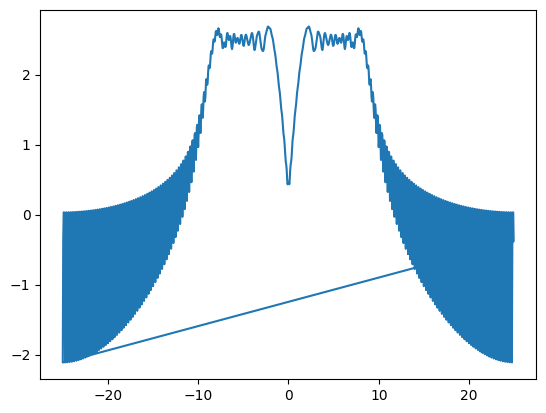

In [54]:
x = np.linspace(-10, 10, 1000)
waveform1 = lfm_chirp(x, 0, 1, 2, 4)
waveform2 = lfm_chirp(x, 0, 1, 2, 4)
freqs = np.fft.fftfreq(len(x), d=(x[1] - x[0]))
# print(freqs[0], freqs[1])
waveform_freq1 = np.fft.fft(waveform1)
waveform_freq2 = np.fft.fft(waveform2)
combined = waveform_freq1 * waveform_freq2.conj()
# plt.plot(freqs, np.real(waveform_freq1))
# plt.plot(freqs, np.imag(waveform_freq1))
# plt.plot(freqs, np.abs(waveform_freq1))

# plt.plot(freqs, np.log10(waveform_freq1))
plt.plot(freqs[1:], np.log10(combined)[1:])

# plt.plot(freqs, waveform_freq2)
# plt.plot(freqs, np.abs(waveform_freq1 * waveform_freq2.conj()))
plt.show()

# Title: How a radar determines range
## Section 1: How a radar determines range
- Talk about trasnmitting sine wave and receiving it
- Show plot modelling sending sin(wt) and receiving it at time sin(w(t-t0))
- Talk about how we can compute distance (range) to a point by computing R = c * t / 2
- Talk about resolution of using a pusle sin wave
    - add plot showing resolution of two pulses close together
- Talk about max unambiguous range

This is what I was gonna do for all of next week but I think it's too smol

## Section 2: Introduct problem
- Talk about problem of wanting fine resolution but problem of transmitting short for same amount of energy of long pulse is complicated and too hord

## Section 3: Math primer?
- Basic of convolution?
- Basic of complex numbers (complex exponential)?
- Basic of fourier transform?
    - Talk about negative frequencies

## Section 4: Sowution to Section 2: Use LFM
Idk feel free to break it up but I want to talk about matched filtering and stuff here and pulse compression stuff

- Define matched filter
    - Filter dat be maximizing that SNR tho
- Introduce LFM and some plots around it
- Derive matched filter output for transmitting baseband LFM and receiving it at time later $t_d$ aka $e^{\pi \gamma (t - t_d)^2}$
    - Basically want to show how the output ends up being sinc function with peak correspoding to time delay $t_d$
## Section 5: Stretch processing
- Show how we matched filter directly with hardware

## Section 6: Stepped frequency waveforms
- Talk about ye ol step chirp waveforms

